# Multivariate Time Series Forecasting with LSTM

### Import Data

In [298]:
import pickle

model_file_path = '../market_trading/data/featurized_market_data.p'

with open(model_file_path, 'rb') as fp:
    featurized_market_data = pickle.load(fp)

### Import Dependencies

In [299]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

### Prepare Data

In [300]:
# Separate time from the rest of the data.
pair_name = 'AAVE_BTC'
features = featurized_market_data[pair_name].dropna().set_index('time')

In [301]:
# Scale the data.
## LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized.
scaler = StandardScaler()
scaler = scaler.fit(features)
features_scaled = scaler.transform(features)

In [302]:
# Prepare training and prediction sliding windowed buckets.
features_current_past = []
features_future = []

# Count of steps to forecast into the future.
n_future_step_count = 1
# Count of steps to consider historically including the current step.
n_past_step_count_inc_current = 24
column_index_to_predict = 3

for i in range(n_past_step_count_inc_current, len(features_scaled) - n_future_step_count + 1):
    features_current_past.append(features_scaled[i - n_past_step_count_inc_current : i])
    features_future.append(features_scaled[i + n_future_step_count - 1 : i + n_future_step_count, column_index_to_predict])
    
features_current_past, features_future = np.array(features_current_past), np.array(features_future)

In [303]:
print(f'Past Window Shape: {features_current_past.shape}')
print(f'Future Window Shape: {features_future.shape}')

Past Window Shape: (8802, 24, 35)
Future Window Shape: (8802, 1)


In [304]:
index_to_inspect = 0
# -1 takes the last record in each windows (the current one of that window). Anything apart from -1 would be historical records for context / experience replay.
most_recent_features = features_current_past[index_to_inspect + 1][-1]

assert features_future[index_to_inspect] == most_recent_features[column_index_to_predict], 'The first future price should be the same as the following current price for the prediction column.'

### Setup Network

In [305]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(features_current_past.shape[1], features_current_past.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(features_future.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 24, 64)            25600     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 38,049
Trainable params: 38,049
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [306]:
history = model.fit(features_current_past, features_future, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
496/496 [==============================] - 8s 12ms/step - loss: 0.0670 - val_loss: 0.0049
Epoch 2/10
496/496 [==============================] - 5s 11ms/step - loss: 0.0358 - val_loss: 0.0035
Epoch 3/10
496/496 [==============================] - 6s 11ms/step - loss: 0.0299 - val_loss: 0.0020
Epoch 4/10
496/496 [==============================] - 5s 11ms/step - loss: 0.0272 - val_loss: 0.0016
Epoch 5/10
496/496 [==============================] - 5s 11ms/step - loss: 0.0263 - val_loss: 0.0021
Epoch 6/10
496/496 [==============================] - 5s 11ms/step - loss: 0.0254 - val_loss: 0.0019
Epoch 7/10
496/496 [==============================] - 6s 11ms/step - loss: 0.0275 - val_loss: 0.0022
Epoch 8/10
496/496 [==============================] - 6s 12ms/step - loss: 0.0253 - val_loss: 0.0014
Epoch 9/10
496/496 [==============================] - 6s 11ms/step - loss: 0.0278 - val_loss: 0.0016
Epoch 10/10
496/496 [==============================] - 5s 11ms/step - loss: 0.0248 - val_lo

### Visualize Results

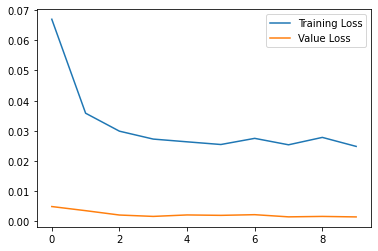

In [307]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Value Loss')
plt.legend()

### Make a Prediction

In [308]:
forecast_record_count = 24
forecast_frequency = '1h'
forecast_period_dates = pd.date_range(list(features.index)[-1], periods=forecast_record_count, freq=forecast_frequency).tolist()
forecast = model.predict(features_current_past[-forecast_record_count:])

In [309]:
# Perform inverse scaling.
shaped_forecast = np.repeat(forecast, features.shape[1], axis=-1)
scaled_forecasts = scaler.inverse_transform(shaped_forecast)[:, column_index_to_predict]
forecast_df = pd.DataFrame({ 'time': np.array(forecast_period_dates), 'close': np.array(scaled_forecasts) }).set_index('time')

In [310]:
features[-1:].index

DatetimeIndex(['2021-10-20 05:00:00'], dtype='datetime64[ns]', name='time', freq=None)

In [311]:
forecast_df[:1].index

DatetimeIndex(['2021-10-20 05:00:00'], dtype='datetime64[ns]', name='time', freq=None)

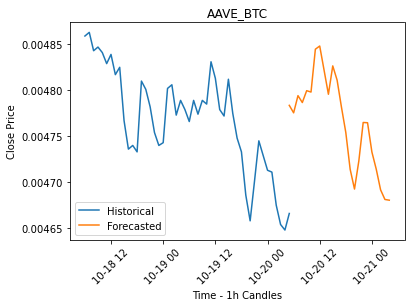

In [313]:
historical_steps_to_visualize = 48
plt.title(pair_name)
plt.plot(features['close'][-historical_steps_to_visualize:], label='Historical')
plt.plot(forecast_df['close'], label='Forecasted')
plt.xlabel('Time - 1h Candles')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()

### References
- [Documentation](https://timeseriestransformer.readthedocs.io/en/latest/README.html)